In [1]:
# libraries
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
data_dir = '/content/drive/MyDrive/kaggle'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.shape)
print(test.shape)
train.head()

(15035, 21)
(6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [3]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 데이터 전처리

In [4]:
# train, test 합쳐서 한번에 전처리

train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

21503


In [5]:
# 결측치 확인
for c in data.columns:
  print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [6]:
# date 데이타 int형으로 변환
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
# 학습에 불필요한 'id'행 삭제
del data['id']

print(data.columns)
print(len(data.columns))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
19


### 변수별로 분포 확인

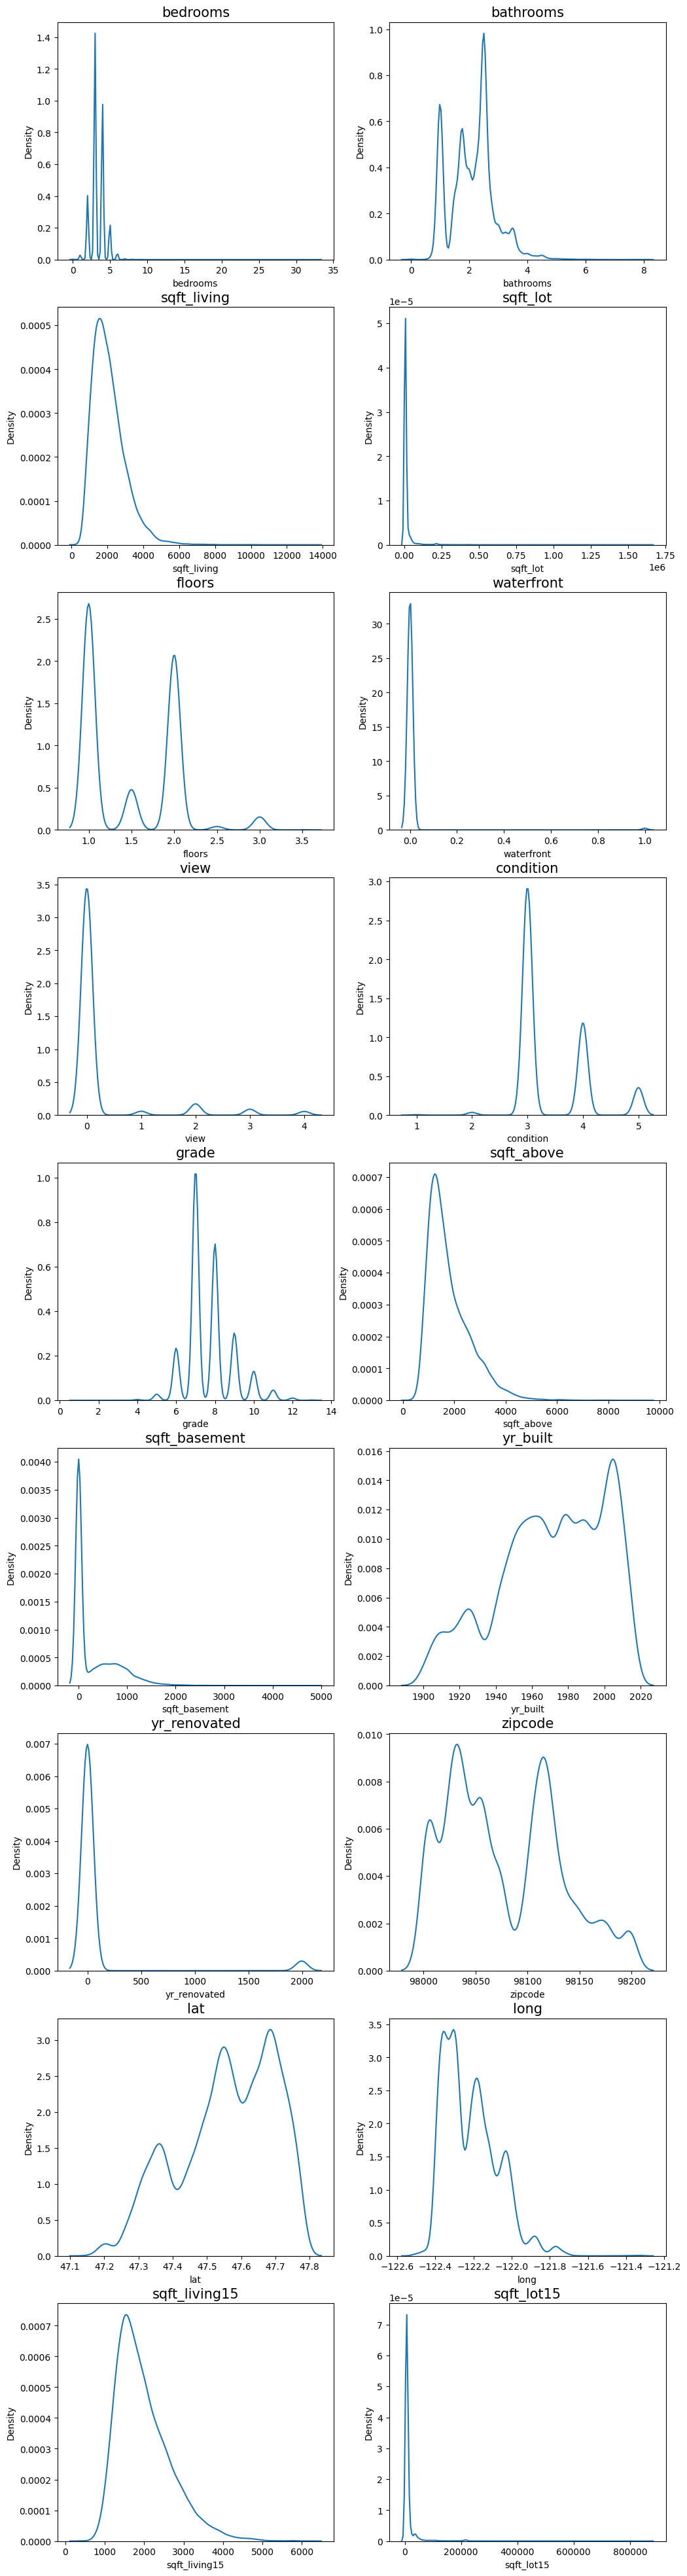

In [8]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# data 변수를 제외하고 (0인덱스 제외하고) 확인한다
count = 1
columns = data.columns
for row in range(9):
  for col in range(2):
    sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
    ax[row][col].set_title(columns[count], fontsize=15)
    count += 1
    if count == 19:
      break

In [9]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
  data[c] = np.log1p(data[c].values)

### train / test split

In [10]:
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  float64
 18  sqft_l

### y의 분포 확인과 전처리

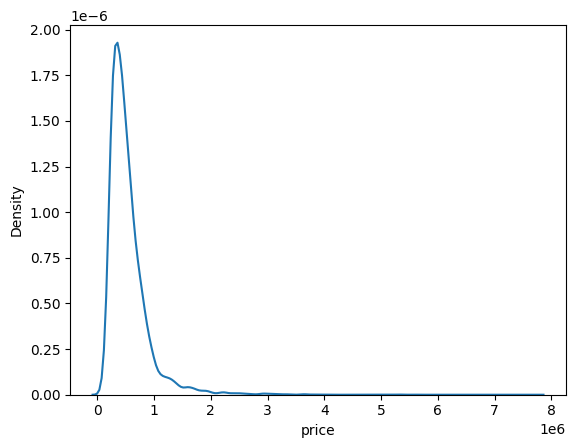

In [12]:
sns.kdeplot(y)
plt.show()

y의 데이터도 한 쪽으로 많이 치우쳐져 있다. 학습에 더 용이하도록 로그 변환을 통해 정규분포와 비슷해지도록 처리.

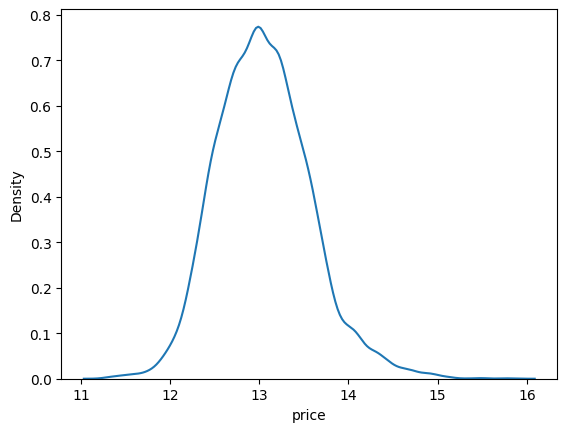

In [13]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

### HYPER PARAMTER TUNING

GridSearch 함수
- 최적의 하이퍼 파라미터 값을 찾기 위한 GridSearchCV를 이용.

-- 각 하이퍼 파라미터의 조합의 negative mean squared error와 RMSLE(Root Mean Squared Log Error)를 출력해주는 기능을 하는데, 이를 이용하여 RMSLE가 가장 낮은, 즉 성능이 가장 좋은 모델을 찾고자 한다

In [14]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
  #GridSearchCV 모델로 초기화
  grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                            cv=4, verbose=verbose, n_jobs=n_jobs )

  #모델 fit
  grid_model.fit(train, y)

  #결과값 저장
  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']

  #데이터 프레임 생성
  results = pd.DataFrame(params)
  results['score'] = score

  #RMLSE 값 계산 후 정렬
  results['RMSLE'] = np.sqrt(-1 * results['score'])
  results = results.sort_values('RMSLE')

  return results

In [15]:
# 그리드 탐색에서 이용할 모델의 객체를 미리 생성한다
random_state = 42

#rdforest = RandomForestRegressor(random_state=random_state, bootstrap=False)
gboost = GradientBoostingRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state, tree_method='gpu_hist')

GradientBoostingRegressor 그리드 탐색

In [16]:
param_grid={'learning_rate': [0.01,0.03,0.1],
            'n_estimators': [200, 500, 700],
            'max_depth' : [6, 9]
            }

In [17]:
search_results_gb = my_GridSearch(gboost, train, y, param_grid, verbose=1, n_jobs=1)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


In [18]:
search_results_gb.head(10)

,learning_rate,max_depth,n_estimators,score,RMSLE
8,0.03,6,700,-0.026653,0.163258
7,0.03,6,500,-0.026911,0.164046
12,0.10,6,200,-0.027204,0.164936
13,0.10,6,500,-0.027232,0.165021
14,0.10,6,700,-0.027451,0.165683
10,0.03,9,500,-0.028335,0.168331
11,0.03,9,700,-0.028338,0.168339
2,0.01,6,700,-0.028486,0.168779
5,0.01,9,700,-0.028595,0.169101
9,0.03,9,200,-0.028712,0.169446


In [19]:
search_results_gb.iloc[0]

learning_rate      0.030000
max_depth          6.000000
n_estimators     700.000000
score             -0.026653
RMSLE              0.163258
Name: 8, dtype: float64

LGBM(Light Gradient Boosting Machine) Regressor 그리드 탐색

In [20]:
param_grid ={'learning_rate': [0.03,0.1],
             'n_estimators' : [200,500, 700],
             'max_depth'    : [-1, 6, 9],
             'num_leaves'   : [31, 45, 62],
             'colsample_bytree' : [0.3, 0.7],
             'boosting_type': ['gbdt']#, 'dart']
}

In [21]:
search_results_lgbm = my_GridSearch(lightgbm, train, y, param_grid, verbose=1, n_jobs=-1)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


In [22]:
search_results_lgbm.head(10)

,boosting_type,colsample_bytree,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
61,gbdt,0.7,0.03,-1,700,45,-0.025456,0.159548
79,gbdt,0.7,0.03,9,700,45,-0.025488,0.159651
78,gbdt,0.7,0.03,9,700,31,-0.025592,0.159976
60,gbdt,0.7,0.03,-1,700,31,-0.025594,0.159982
80,gbdt,0.7,0.03,9,700,62,-0.025633,0.160105
58,gbdt,0.7,0.03,-1,500,45,-0.025635,0.160109
62,gbdt,0.7,0.03,-1,700,62,-0.025655,0.160172
76,gbdt,0.7,0.03,9,500,45,-0.025702,0.160318
59,gbdt,0.7,0.03,-1,500,62,-0.025731,0.160408
77,gbdt,0.7,0.03,9,500,62,-0.025733,0.160415


In [23]:
search_results_lgbm.iloc[0]

boosting_type           gbdt
colsample_bytree         0.7
learning_rate           0.03
max_depth                 -1
n_estimators             700
num_leaves                45
score              -0.025456
RMSLE               0.159548
Name: 61, dtype: object

### XGBRegressor

In [24]:
param_grid ={ 'max_depth': [6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [500, 700],
           'colsample_bytree': [0.3, 0.7]
}

In [25]:
search_results_xgb = my_GridSearch(xgboost, train, y, param_grid, verbose=1, n_jobs=-1)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


ValueError: ignored

In [26]:
search_results_xgb.head(10)

NameError: ignored

In [ ]:
search_results_xgb.iloc[0]

### 최적화된 모델들 이용하여 blending 모델로 결과 생성
____________________
그리드 탐색을 통해 찾은 각 모델별 파라미터를 적용하여 모델을 생성

In [27]:
random_state = 42

gboost = GradientBoostingRegressor(random_state=random_state, learning_rate=0.030000,
                                   max_depth=6, n_estimators=700)

lightgbm = LGBMRegressor(random_state=random_state, boosting_type='gbdt', learning_rate=0.03,
                         max_depth=-1, n_estimators=700, colsample_bytree=0.7, num_leaves=45)

xgboost = XGBRegressor(random_state=random_state, booster='gbtree', learning_rate=0.05,
                       max_depth=6, n_estimators=700, colsample_bytree=0.7)

models = [gboost, lightgbm, xgboost]#, rdforest]

In [28]:
def WeightedBlending(models, train, y, test):
    for m in models :
        m.fit(train.values, y)

    predictions = ((0.2*np.expm1(models[0].predict(test))) + #Gradient Boosting
                   (0.4*np.expm1(models[1].predict(test))) + # LightGBM
                   (0.4*np.expm1(models[2].predict(test)))) #XGBoost

    return predictions

In [29]:
y_pred = WeightedBlending(models, train, y, test)
print(len(y_pred))
y_pred

6468


array([ 513520.03552958,  477248.52429829, 1390118.61909721, ...,
        463464.25590907,  328081.68439755,  439030.98574517])

### 예측 결과 파일에 저장

In [30]:
data_dir = '/content/drive/MyDrive/kaggle'
dest_dir = '/content/drive/MyDrive/kaggle'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = y_pred
submission_csv_path = '{}/submission_blending_final.csv'.format(dest_dir)
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

/content/drive/MyDrive/kaggle/submission_blending_final.csv saved!
